In [107]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

## **I] Trouver la DB**
#### DB 'tips' de Seaborn.

## **II] DB -> DF**

In [108]:
df = sns.load_dataset('tips')
df.head(3)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3


## **III] Data analyse/visualisation**

In [109]:
df_dummies = pd.get_dummies(df)
df_dummies.head(3)

,total_bill,tip,size,sex_Male,sex_Female,smoker_Yes,smoker_No,day_Thur,day_Fri,day_Sat,day_Sun,time_Lunch,time_Dinner
0,16.99,1.01,2,0,1,0,1,0,0,0,1,0,1
1,10.34,1.66,3,1,0,0,1,0,0,0,1,0,1
2,21.01,3.50,3,1,0,0,1,0,0,0,1,0,1


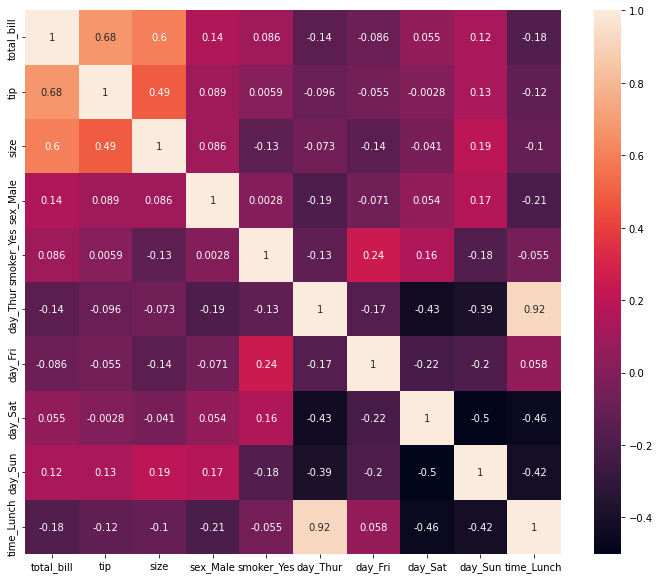

In [110]:
corr = df_dummies.drop(columns=['sex_Female', 'smoker_No', 'time_Dinner']).corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True)
plt.show()

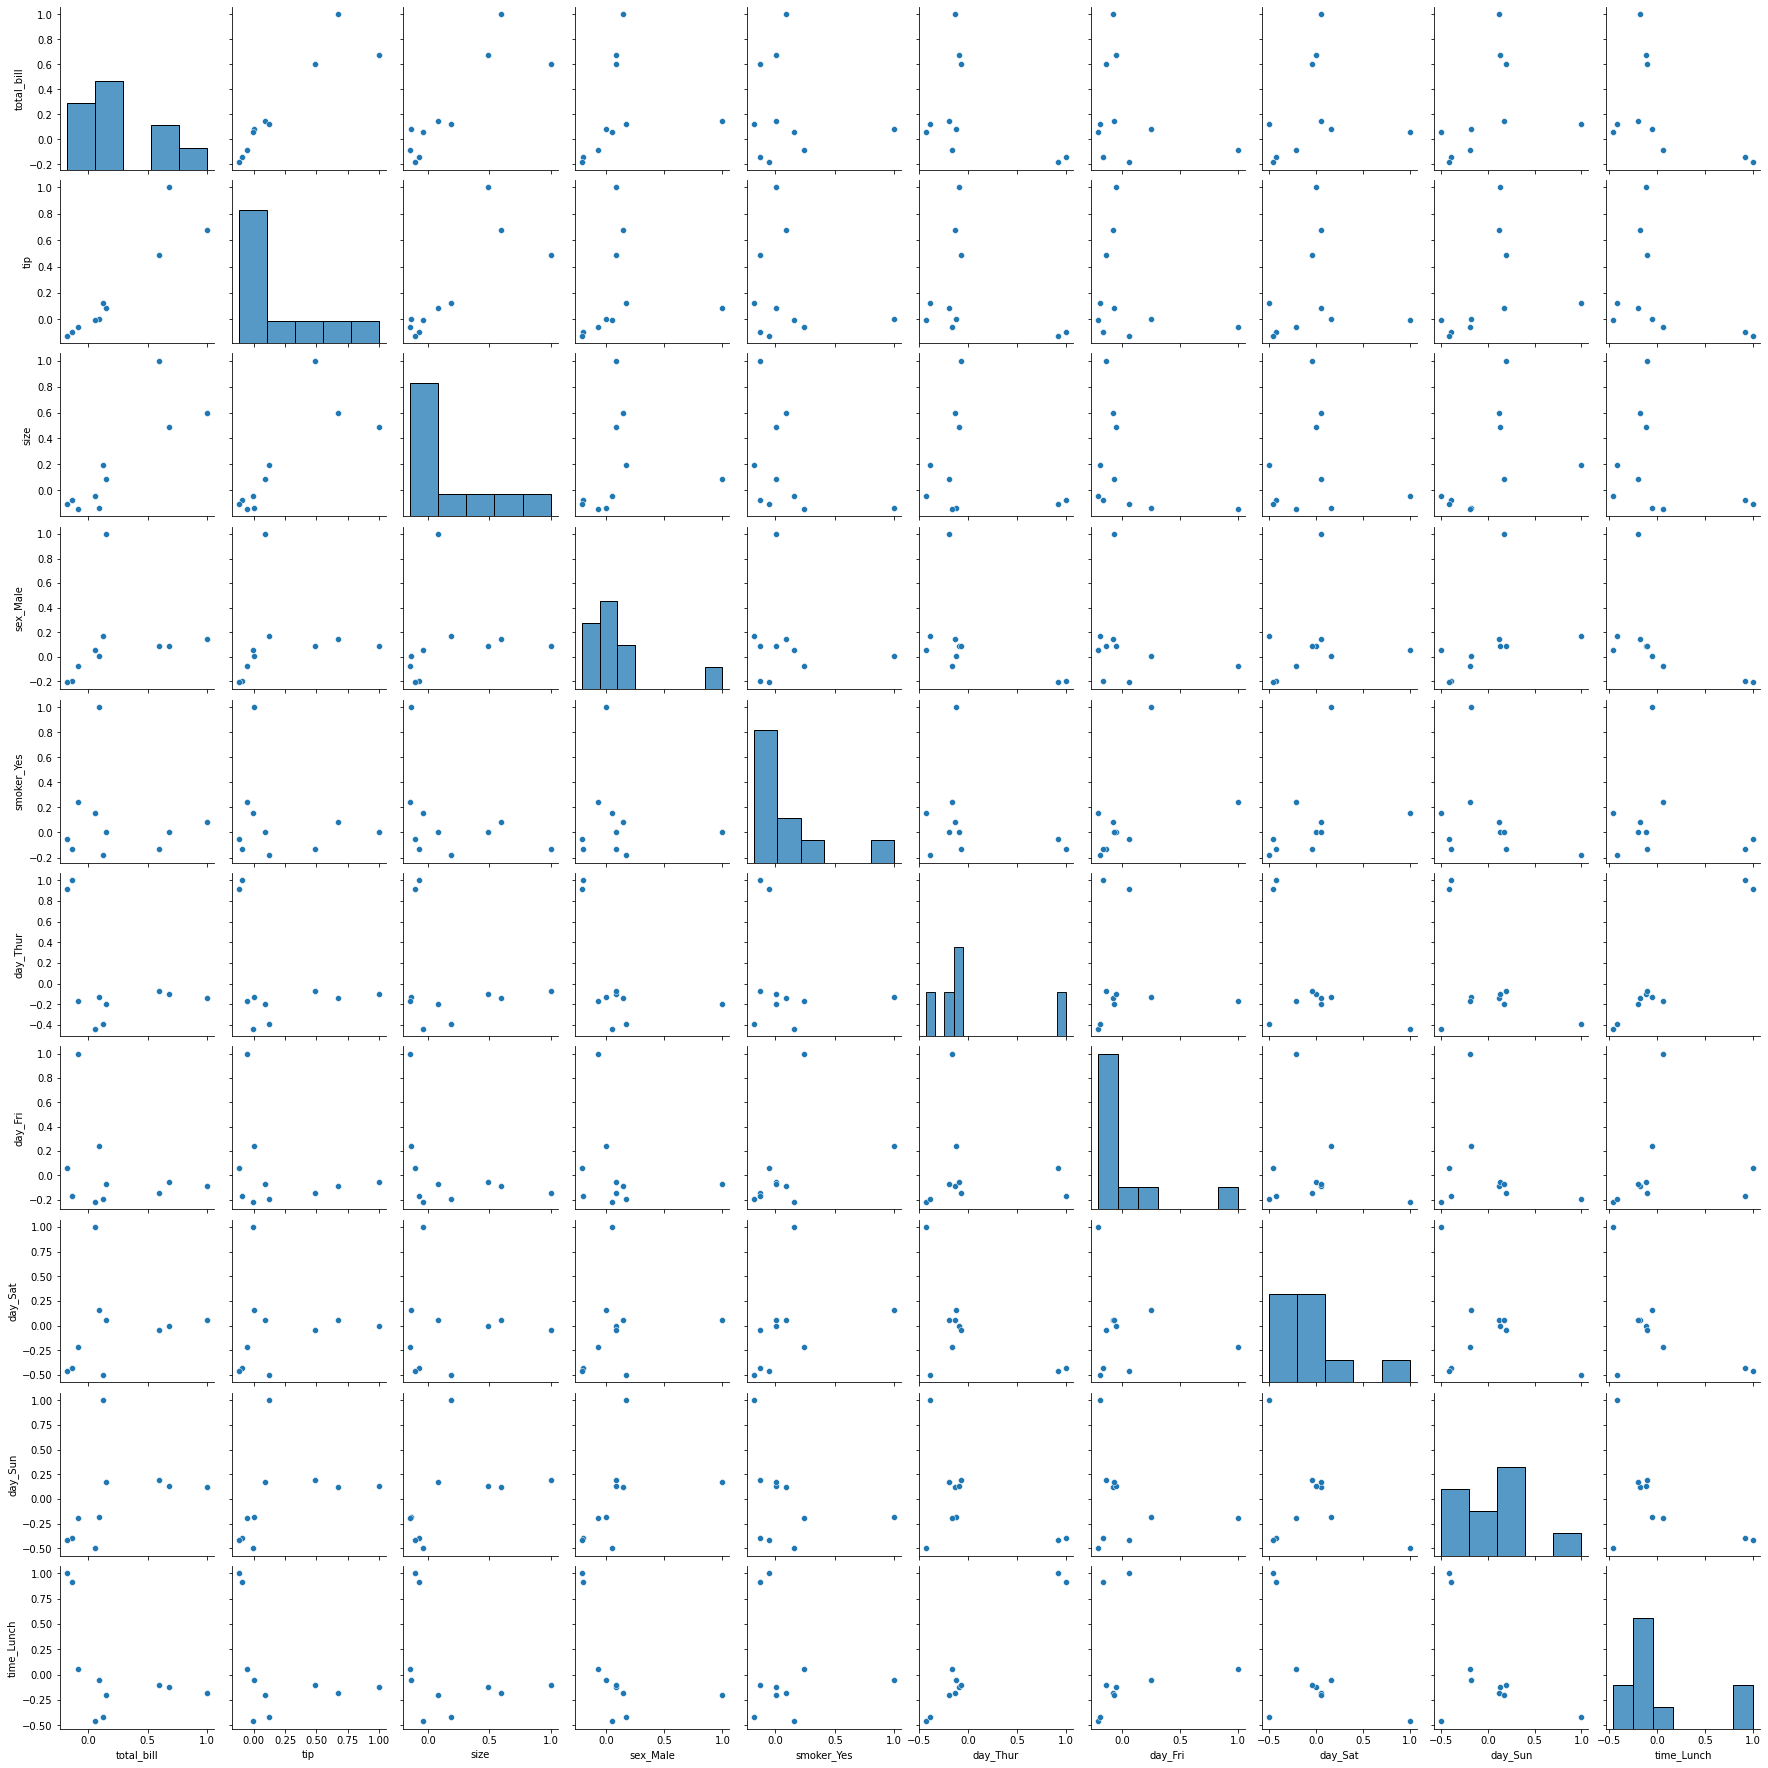

In [111]:
sns.pairplot(corr);

#### Pour y = 'total_bill', on garde en variables explicatives x1 = 'tip' et x2 = 'size'

In [112]:
df_clean = df[['total_bill', 'tip', 'size']]

In [113]:
mms = MinMaxScaler()

def scale(X_train, X_test):
    mms.fit(X_train)
    return pd.DataFrame(mms.transform(X_test))

## Modèle pour y en fonction de x1

In [114]:
x1 = df[['tip']]
y = df['total_bill']

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y, test_size=0.3)

In [115]:
lr1 = LinearRegression()

In [116]:
x1_train_prep = scale(x1_train, x1_train)
x1_test_prep = scale(x1_train, x1_test)

In [117]:
cross_validate(lr1, x1_train_prep, y1_train)['test_score'].mean()

0.32983755102730333

In [118]:
lr1.fit(x1_train_prep, y1_train)
lr1.score(x1_test_prep, y1_test)

0.5373059222414069

In [133]:
y1_pred = lr1.predict(x1_test_prep)

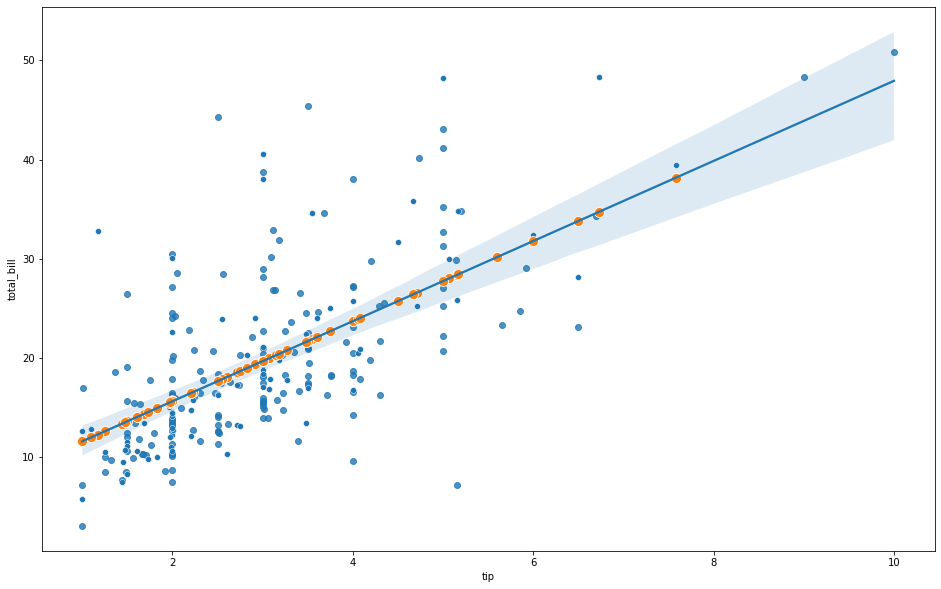

In [137]:
plt.figure(figsize=(16,10))
sns.regplot(x=x1_train['tip'], y=y1_train)
sns.scatterplot(x=x1_test['tip'], y=y1_test)
sns.scatterplot(x=x1_test['tip'], y=y1_pred, s=100)
plt.show()

## Modèle pour y en fonction de x1 et x2

In [120]:
lr2 = LinearRegression()

In [121]:
X = df[['tip','size']]

X_train, X_test, y2_train, y2_test = train_test_split(X, y, test_size=0.3)

In [122]:
X_train_prep = scale(X_train, X_train)
X_test_prep = scale(X_train, X_test)

In [123]:
cross_validate(lr2, X_train_prep, y2_train)['test_score'].mean()

0.49694449137065516

In [124]:
lr2.fit(X_train_prep, y2_train)
lr2.score(X_test_prep, y2_test)

0.5619991365331656

In [138]:
y2_pred = lr2.predict(X_test_prep)

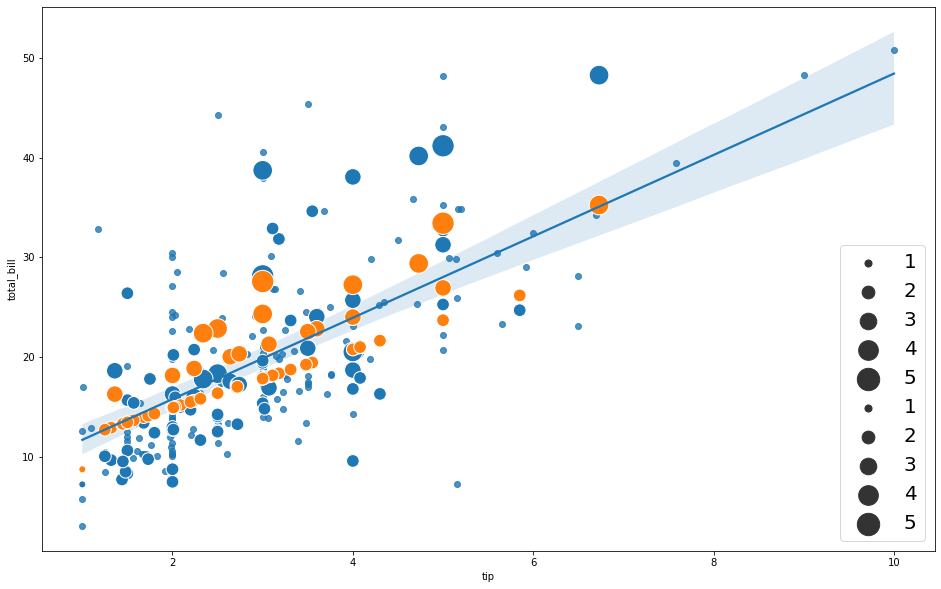

In [140]:
plt.figure(figsize=(16,10))
sns.regplot(x=X_train['tip'], y=y2_train)
sns.scatterplot(x=X_test['tip'], y=y2_test, size=X_test['size'], sizes=(50, 500))
sns.scatterplot(x=X_test['tip'], y=y2_pred, size=X_test['size'], sizes=(50, 500))
plt.legend(fontsize=20)
plt.show()

In [151]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
import pickle
from sklearn import set_config
set_config(display="diagram") 

In [146]:
df2 = sns.load_dataset('tips')
df2.head(3)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3


In [152]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        sex_dct = {'Male' : 0, 'Female' : 1}
        X['sex'] = [sex_dct[s] for s in X['sex']]
        
        smoker_dct = {'No' : 0, 'Yes' : 1}
        X['smoker'] = [smoker_dct[s] for s in X['sex']]
        
        time_dict = {'Lunch': 0, 'Dinner' : 1}
        X['time'] = [time_dict[t] for t in X['sex']]
        
        encoder = OneHotEncoder()
        matrix = encoder.fit_transform(X[['day']]).toarray()
        columnn_names = ['Thur', 'Fri', 'Sat', 'Sun']
        for i in range(len(matrix.T)): X[columnn_names[i]] = matrix.T[i]
            
        return X.drop('day', axis=1)

In [153]:
pipe_encoder = ColumnTransformer([('X_num', MinMaxScaler(), ['total_bill', 'size']), ('X_cat', FeatureEncoder(), ['sex', 'smoker', 'day', 'time'])])

In [154]:
pipe = Pipeline([('encoder', pipe_encoder), ('estimator', LinearRegression())])

In [157]:
pipe

Pipeline(steps=[('encoder',
                 ColumnTransformer(transformers=[('X_num', MinMaxScaler(),
                                                  ['total_bill', 'size']),
                                                 ('X_cat', FeatureEncoder(),
                                                  ['sex', 'smoker', 'day',
                                                   'time'])])),
                ('estimator', LinearRegression())])